In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  RBF


import Bgolearn.BGOsampling as BGOS 

In [29]:
def True_function(X):
    X = np.array(X)
    Y = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8
    return Y

In [30]:
def generate_function(data, obs):
    print('------------12 original data-----------')
    data = np.array(data)
    # for one feature dataset
    data_matrix = np.array(data[:,0]).reshape(-1, 1)

    Measured_response = np.zeros(len(data_matrix))
    for i in range(obs):
        Measured_response += np.array(data[:,i+1])
    # for one feature dataset
    Measured_response = Measured_response/obs
    
    Measured_std = []
    for j in range(len(data_matrix)):
        std = np.std(np.array(data[j,1:1+obs]))
        Measured_std.append(std)
    Measured_std = np.array(Measured_std)  
    print('evaluated mean of y :', Measured_response)
    print('evaluated std of y :', Measured_std)
    print('---------------------------------------\n')
    return data_matrix,Measured_response,Measured_std

## design virtual samples

In [31]:
virtual_samples = np.linspace(0,11,100)

## define a callable Kriging model and sampling function

In [32]:
def Sam_function(X,real_std,obs):
    print('--------------Draw samples-------------')
    print('real std of added datum:', real_std)
    X = np.array(X)
    Y = np.zeros(1)
    Y_list = []
    for i in range(obs):
        __sam = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8 + np.random.normal(loc=0.0, scale=real_std, size=None)
        Y_list.append(__sam)
        Y += __sam
        print(i+1,'-th sampling, result = ', __sam)
    cal_std = np.std(np.array(Y_list))
    print('evaluated mean of added datum:', Y/obs)
    print('evaluated std of added datum:', cal_std)
    print('---------------------------------------\n')
    return Y/obs, np.array(cal_std)


## instantiate Bgolearn

In [33]:
Bgolearn = BGOS.Bgolearn()
method_name = 'EI'


------------12 original data-----------
evaluated mean of y : [6.21494888 5.56581958 4.61988109 4.34056442 4.35646479 4.67190767
 4.62173112 4.55605355 4.70138419 4.48867457 5.8769712  7.75473896]
evaluated std of y : [0.30008321 0.2742029  0.07394358 0.91538122 0.33136727 0.29720623
 0.07801782 0.48293232 0.24548787 0.12272781 0.21645983 0.25832216]
---------------------------------------

current optimal is : 4.340564424
The next datum recomended by Expected Improvement : 
 x =  [8.44444444]
--------------Draw samples-------------
real std of added datum: 0.7
1 -th sampling, result =  3.059089844513986
2 -th sampling, result =  3.265179592371137
3 -th sampling, result =  3.878512926630604
evaluated mean of added datum: [3.40092745]
evaluated std of added datum: 0.3480269706328898
---------------------------------------

1-th iteration 
 new added datum: [8.4, array([3.4009])]


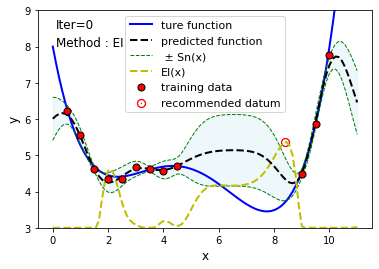

current optimal is : 3.4009
The next datum recomended by Expected Improvement : 
 x =  [8.]
--------------Draw samples-------------
real std of added datum: 0.5
1 -th sampling, result =  2.6753156172997645
2 -th sampling, result =  3.254724091856313
3 -th sampling, result =  3.7525149549545875
evaluated mean of added datum: [3.22751822]
evaluated std of added datum: 0.44018535702033285
---------------------------------------

2-th iteration 
 new added datum: [8.0, array([3.2275])]


<Figure size 432x288 with 0 Axes>

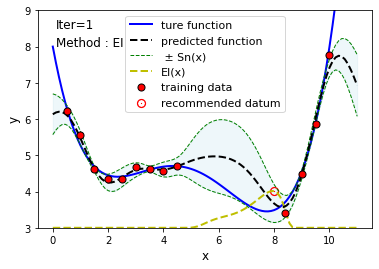

current optimal is : 3.2275
The next datum recomended by Expected Improvement : 
 x =  [7.77777778]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  3.260273673051346
2 -th sampling, result =  4.853261108233976
3 -th sampling, result =  3.170169852206738
evaluated mean of added datum: [3.76123488]
evaluated std of added datum: 0.773054823648497
---------------------------------------

3-th iteration 
 new added datum: [7.8, array([3.7612])]


<Figure size 432x288 with 0 Axes>

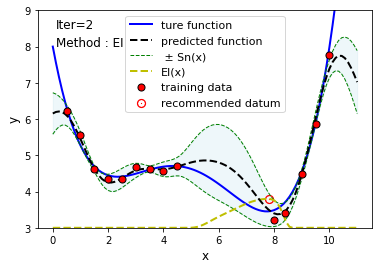

<Figure size 432x288 with 0 Axes>

In [35]:
obs = 3

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.EI()*10 + 3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,8,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,8.5,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break

------------12 original data-----------
evaluated mean of y : [6.29185161 5.39856881 4.62623151 4.38385368 4.46148423 4.63694734
 4.5905237  4.59016103 4.67177078 4.4811777  5.95522378 7.80150911]
evaluated std of y : [0.29202661 0.37457828 0.06497479 0.79628133 0.33976528 0.26441507
 0.08652626 0.42238334 0.21869861 0.10707566 0.23132562 0.23792876]
---------------------------------------

current optimal is : 4.383853676
The next datum recomended by Expected Improvement : 
 x =  [8.44444444]
--------------Draw samples-------------
real std of added datum: 0.1
1 -th sampling, result =  3.62324654955125
2 -th sampling, result =  3.9290317189938615
3 -th sampling, result =  3.8521347873893212
4 -th sampling, result =  3.710423767532894
evaluated mean of added datum: [3.77870921]
evaluated std of added datum: 0.1191844291129262
---------------------------------------

1-th iteration 
 new added datum: [8.4, array([3.7787])]


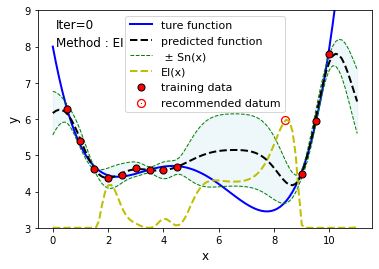

current optimal is : 3.7787
The next datum recomended by Expected Improvement : 
 x =  [7.33333333]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  3.747728486882819
2 -th sampling, result =  3.978098366871831
3 -th sampling, result =  3.3510625819661684
4 -th sampling, result =  3.313864187015999
evaluated mean of added datum: [3.59768841]
evaluated std of added datum: 0.2777608002238956
---------------------------------------

2-th iteration 
 new added datum: [7.3, array([3.5977])]


<Figure size 432x288 with 0 Axes>

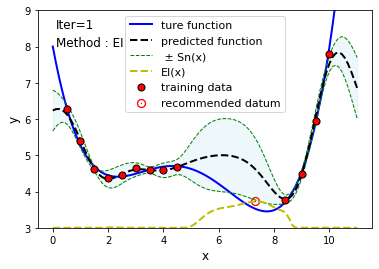

current optimal is : 3.5977
The next datum recomended by Expected Improvement : 
 x =  [6.55555556]
--------------Draw samples-------------
real std of added datum: 0.5
1 -th sampling, result =  3.8411317876522197
2 -th sampling, result =  4.1275802935873624
3 -th sampling, result =  3.32028400175101
4 -th sampling, result =  2.9773334793093382
evaluated mean of added datum: [3.56658239]
evaluated std of added datum: 0.44664672683923085
---------------------------------------

3-th iteration 
 new added datum: [6.6, array([3.5666])]


<Figure size 432x288 with 0 Axes>

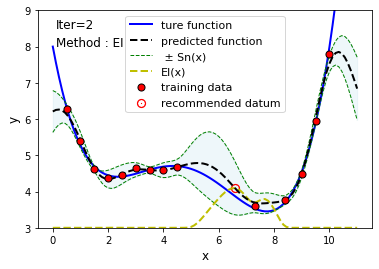

current optimal is : 3.5666
The next datum recomended by Expected Improvement : 
 x =  [6.66666667]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  3.761088692902215
2 -th sampling, result =  3.8187315179143466
3 -th sampling, result =  3.816828245124886
4 -th sampling, result =  3.8021019811003214
evaluated mean of added datum: [3.79968761]
evaluated std of added datum: 0.023195782968388437
---------------------------------------

4-th iteration 
 new added datum: [6.7, array([3.7997])]


<Figure size 432x288 with 0 Axes>

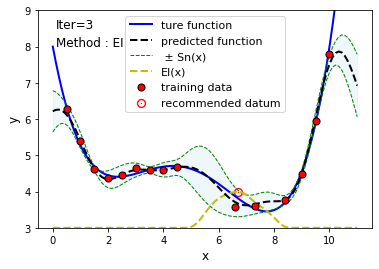

current optimal is : 3.5666
The next datum recomended by Expected Improvement : 
 x =  [7.44444444]
--------------Draw samples-------------
real std of added datum: 0.1
1 -th sampling, result =  3.48001276939807
2 -th sampling, result =  3.509215142364418
3 -th sampling, result =  3.471814254096431
4 -th sampling, result =  3.4364714366201756
evaluated mean of added datum: [3.4743784]
evaluated std of added datum: 0.02592709708959365
---------------------------------------

5-th iteration 
 new added datum: [7.4, array([3.4744])]


<Figure size 432x288 with 0 Axes>

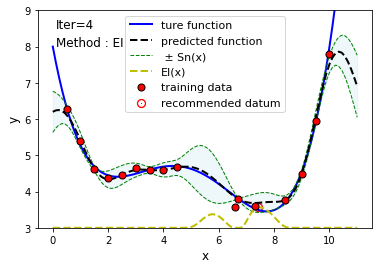

current optimal is : 3.4744
The next datum recomended by Expected Improvement : 
 x =  [7.77777778]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  3.135920158920323
2 -th sampling, result =  3.024760519891947
3 -th sampling, result =  3.529150800270339
4 -th sampling, result =  4.101086575287229
evaluated mean of added datum: [3.44772951]
evaluated std of added datum: 0.4211985040582951
---------------------------------------

6-th iteration 
 new added datum: [7.8, array([3.4477])]


<Figure size 432x288 with 0 Axes>

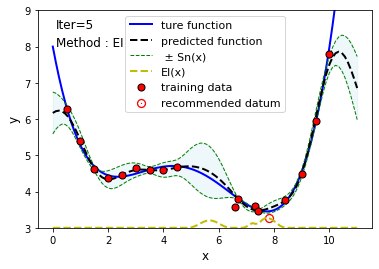

<Figure size 432x288 with 0 Axes>

In [36]:
obs = 4

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.EI()*10 + 3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,8,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,8.5,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break

------------12 original data-----------
evaluated mean of y : [6.38302126 5.47159103 4.62333861 4.45561327 4.45288222 4.66633633
 4.60958967 4.62022357 4.74050698 4.45448135 5.94232697 7.79008494]
evaluated std of y : [0.31854553 0.36548063 0.05840252 0.72653212 0.30438189 0.24369472
 0.0862756  0.38254565 0.23908561 0.10964916 0.20850551 0.21403299]
---------------------------------------

current optimal is : 4.4528822194
The next datum recomended by Expected Improvement : 
 x =  [8.55555556]
--------------Draw samples-------------
real std of added datum: 0.4
1 -th sampling, result =  3.99316305579527
2 -th sampling, result =  4.088931855720532
3 -th sampling, result =  3.5150891460373357
4 -th sampling, result =  4.001359819292395
5 -th sampling, result =  3.8516651330181433
evaluated mean of added datum: [3.8900418]
evaluated std of added datum: 0.20230927332318396
---------------------------------------

1-th iteration 
 new added datum: [8.6, array([3.89])]


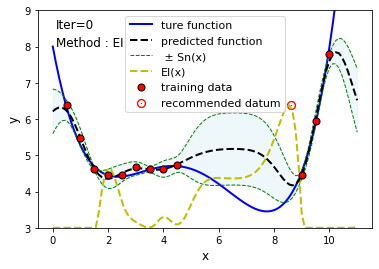

current optimal is : 3.89
The next datum recomended by Expected Improvement : 
 x =  [8.22222222]
--------------Draw samples-------------
real std of added datum: 0.7
1 -th sampling, result =  5.42536560703678
2 -th sampling, result =  3.3974894466273073
3 -th sampling, result =  3.1612213218880836
4 -th sampling, result =  2.8216864035844775
5 -th sampling, result =  3.7736059582338912
evaluated mean of added datum: [3.71587375]
evaluated std of added datum: 0.9093156006884313
---------------------------------------

2-th iteration 
 new added datum: [8.2, array([3.7159])]


<Figure size 432x288 with 0 Axes>

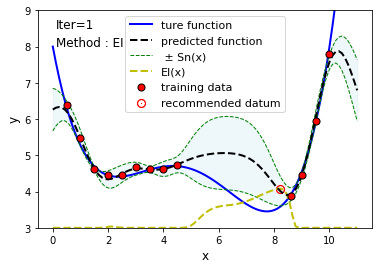

current optimal is : 3.7159
The next datum recomended by Expected Improvement : 
 x =  [7.66666667]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  3.2033917034411883
2 -th sampling, result =  2.6076659111067753
3 -th sampling, result =  3.782110218704572
4 -th sampling, result =  3.405914978433877
5 -th sampling, result =  3.7930433128924417
evaluated mean of added datum: [3.35842522]
evaluated std of added datum: 0.4377972300276209
---------------------------------------

3-th iteration 
 new added datum: [7.7, array([3.3584])]


<Figure size 432x288 with 0 Axes>

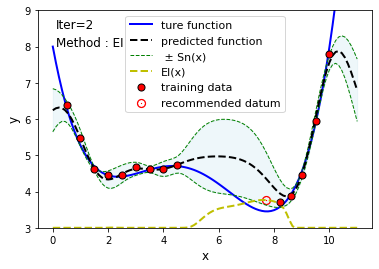

<Figure size 432x288 with 0 Axes>

In [37]:
obs = 5

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.EI()*10 + 3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,8,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,8.5,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break